## Details

#### Name: Akshat Toolaj Sinha
#### Entry Number: 2020CSB1068
#### Equity: Tech Mahindra

## Libraries & Constants

In [35]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import yfinance as yf
import datetime
import matplotlib.dates as mdates
from arch import arch_model
from scipy.stats import norm
import random

In [36]:
# Defining Image Parameters
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_palette('flare')
sns.set_style("darkgrid")
sns.despine()


<Figure size 1200x800 with 0 Axes>

In [37]:
# Defining Constants for the Project

TICKER='TECHM.NS'
PERIOD='max'
FILE_NAME='TECH_MAHINDRA.csv'
PRICE_ANALYSIS='Close'
EQUITY_NAME='Tech Mahindra'
SIGNIFICANCE_LEVEL=0.05
TRADING_DAYS=252
YEAR_DAYS=365
OPTION_EXPIRY=datetime.date(2024,5,31)
TODAY=datetime.date.today()
SEED=0
random.seed(SEED)



# Risk Free Rate for 91 Days
RISK_FREE_RATE= 6.87

## Data Downloading & Augmentation

In [38]:
# Downloading Data
Equity_df=yf.download(TICKER,period=PERIOD,auto_adjust=True)

[*********************100%%**********************]  1 of 1 completed


In [39]:
# Data Cleaning
Equity_df.reset_index(inplace=True)
Equity_df = Equity_df.round(4)

In [40]:
# Dumping Data
Equity_df.to_csv(FILE_NAME,index=False)

## Data Visualization

Plotting Equity price 

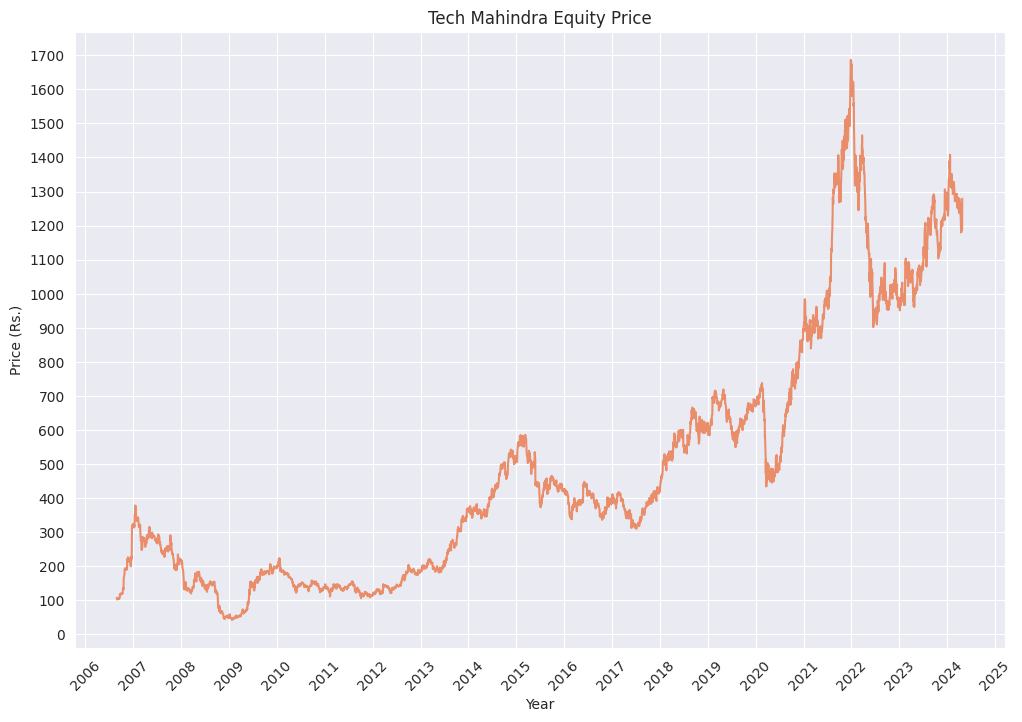

In [41]:
# Plotting Price chart
sns.lineplot(data=Equity_df,x='Date',y=PRICE_ANALYSIS)
plt.xlabel("Year")
plt.ylabel("Price (Rs.)")
plt.title(EQUITY_NAME+ " Equity Price")
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.yticks(range(0,int(max(Equity_df[PRICE_ANALYSIS]))+100,100))
plt.show()

Plotting Log Returns

In [42]:
log_returns=np.log(Equity_df[PRICE_ANALYSIS]/Equity_df[PRICE_ANALYSIS].shift(1))

In [43]:
log_returns=log_returns.dropna()
log_returns.reset_index(drop=True,inplace=True)

In [44]:
log_returns=log_returns*100

In [45]:
dates=Equity_df['Date'][1:]

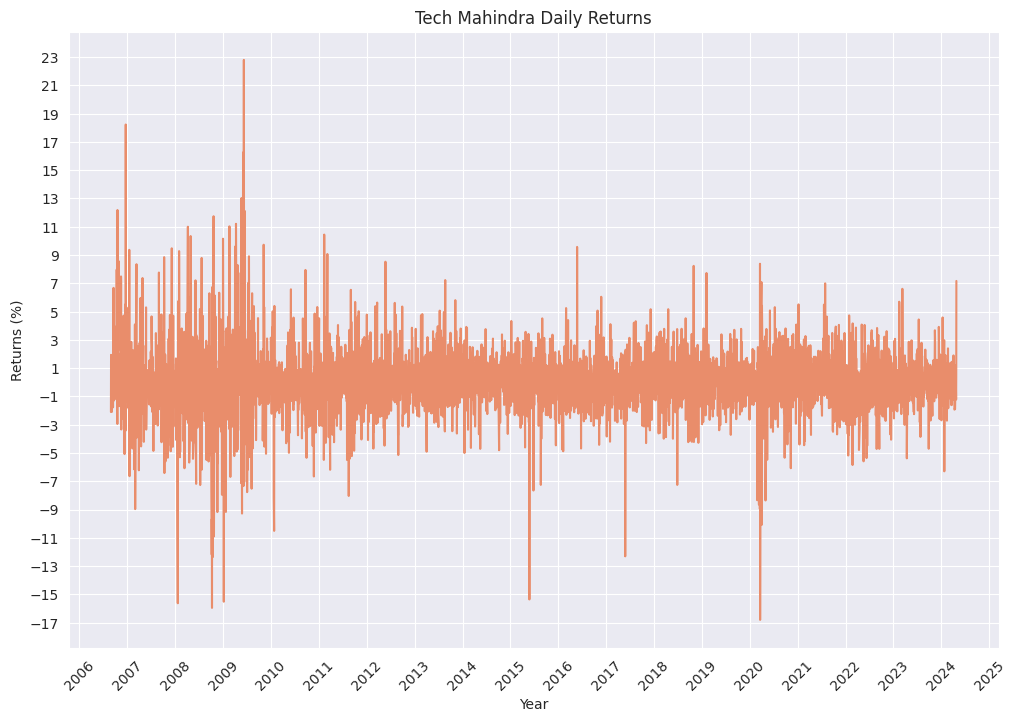

In [46]:
# Plotting Log Returns
sns.lineplot(x=dates,y=log_returns)
plt.xlabel("Year")
plt.ylabel("Returns (%)")
plt.title(EQUITY_NAME+" Daily Returns")
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.yticks(np.arange(int(min(log_returns))-1,max(log_returns)+1,2))
plt.show()

## Normality Tests

Performing various normality test on log returns

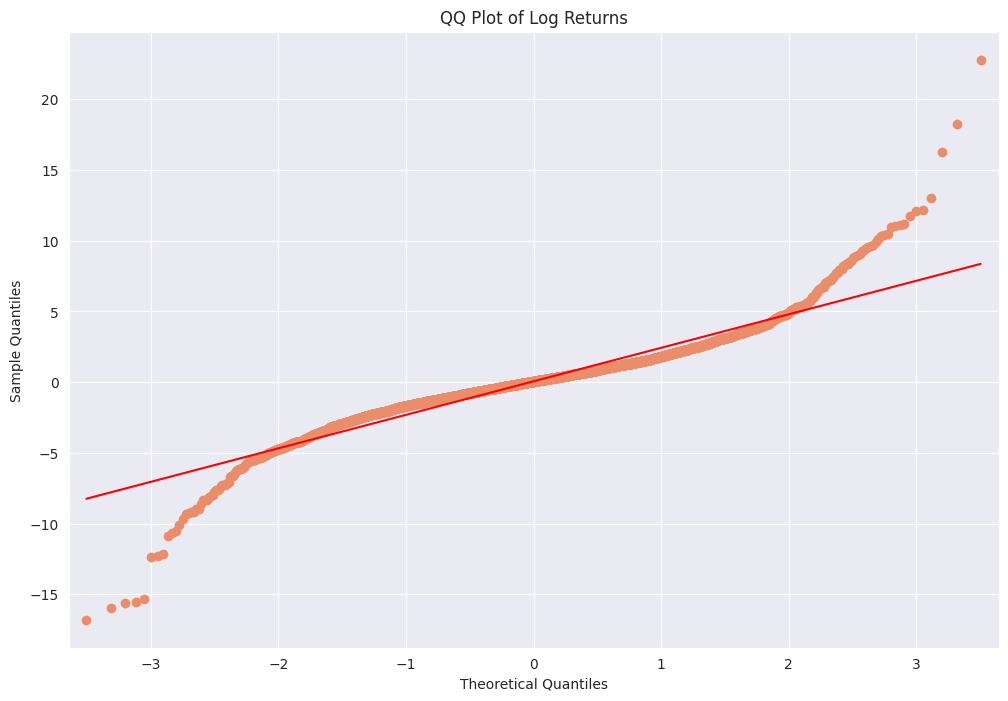

In [47]:
from statsmodels.graphics.gofplots import qqplot

qqplot(log_returns,line='s')
plt.title("QQ Plot of Log Returns")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

<AxesSubplot:xlabel='Close', ylabel='Count'>

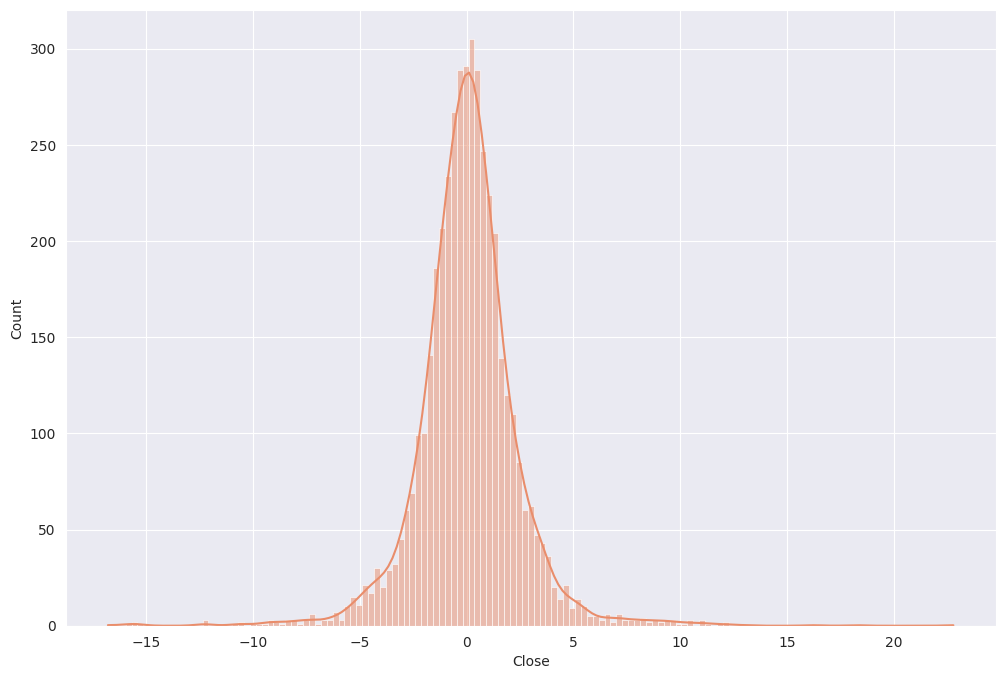

In [48]:
# KDE Plot
sns.histplot(log_returns,kde=True)

In [49]:
# Moment of log-returns distribution
print("Mean of Log Returns: ",round(log_returns.mean(),4))
print("Standard Deviation of Log Returns: ",round(log_returns.std(),4))
print("Skewness of Log Returns: ",round(log_returns.skew(),4))
print("Kurtosis of Log Returns: ",round(log_returns.kurtosis(),4))

Mean of Log Returns:  0.0573
Standard Deviation of Log Returns:  2.3706
Skewness of Log Returns:  0.2041
Kurtosis of Log Returns:  8.5963


Since Kurtosis & Standard Deviation is very high, we have fat tails resulting in leptokurtic distribution which tells that large change are frequent

In [50]:
# Jarque-Bera Test
from scipy.stats import jarque_bera


jb_test=jarque_bera(log_returns)
print("Jarque-Bera Test Statistic: ",jb_test[0])
print("Jarque-Bera Test P-Value: ",jb_test[1])

if jb_test[1]<SIGNIFICANCE_LEVEL:
    print("\nReject Null Hypothesis: The data is not normally distributed")
else:
    print("\nFail to Reject Null Hypothesis : The data is normally distributed")

Jarque-Bera Test Statistic:  13401.325230520446
Jarque-Bera Test P-Value:  0.0

Reject Null Hypothesis: The data is not normally distributed


In [51]:
# Kolmogorov-Smirnov Test
from scipy.stats import kstest

ks_test=kstest(log_returns,'norm')

print("\nKolmogorov-Smirnov Test Statistic: ",ks_test.statistic)
print("Kolmogorov-Smirnov Test P-Value: ",ks_test.pvalue)

if ks_test.pvalue<SIGNIFICANCE_LEVEL:
    print("\nReject Null Hypothesis: The data is not normally distributed")
else:
    print("\nFail to Reject Null Hypothesis : The data is normally distributed")


Kolmogorov-Smirnov Test Statistic:  0.1310342949050758
Kolmogorov-Smirnov Test P-Value:  1.2080874758247278e-65

Reject Null Hypothesis: The data is not normally distributed


In [52]:
# Shapiro-Wilk Test
from scipy.stats import shapiro

shapiro_test=shapiro(log_returns)

print("\nShapiro-Wilk Test Statistic: ",shapiro_test[0])
print("Shapiro-Wilk Test P-Value: ",shapiro_test[1])

if shapiro_test[1]<SIGNIFICANCE_LEVEL:
    print("\nReject Null Hypothesis: The data is not normally distributed")
else:
    print("\nFail to Reject Null Hypothesis : The data is normally distributed")


Shapiro-Wilk Test Statistic:  0.9122287034988403
Shapiro-Wilk Test P-Value:  1.1210387714598537e-44

Reject Null Hypothesis: The data is not normally distributed


## Returns Analysis

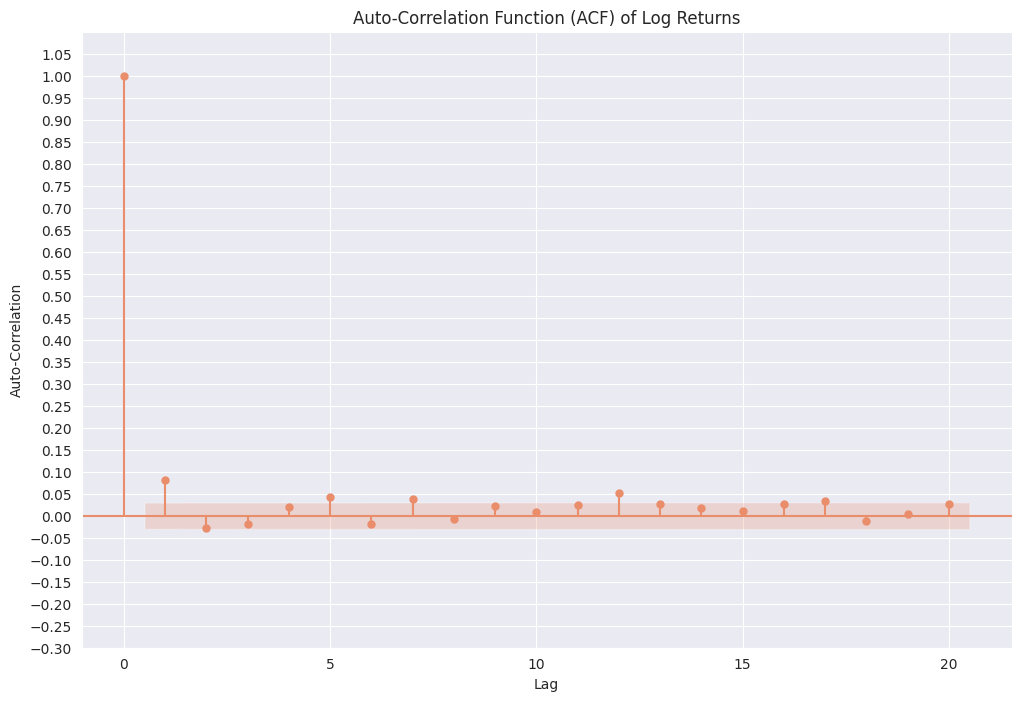

In [53]:
# Autocorrelation test in log Returns

import statsmodels.api as sm

sm.graphics.tsa.plot_acf(log_returns,lags=20)
plt.xlabel('Lag')
plt.ylabel("Auto-Correlation")
plt.title("Auto-Correlation Function (ACF) of Log Returns")
plt.ylim(-0.3,1.1)
plt.yticks(np.arange(-0.3,1.1,0.05))
plt.show()



There is autocorrelation which can be infered from the above graph as even at large timestamp, correlation is breaching the limit

## Volatility Modelling

In [54]:
# Getting standard deviations from log returns to be used a historical volatility
HistoricalVolatility=np.std(log_returns)
AnnualHistoricalVolatility=HistoricalVolatility*math.sqrt(TRADING_DAYS)
print("\nHistorical Daily Volatility (%): ",HistoricalVolatility)
print("Historical Annual Volatility (%): ",AnnualHistoricalVolatility)


Historical Daily Volatility (%):  2.3703735631877034
Historical Annual Volatility (%):  37.628513775100274


In [55]:
# GARCH Modelling and selecting best models from given candidate models

CandidateModels=[(1,1),(1,2),(2,1),(2,2),(3,2),(2,3),(3,3)]

BestModel=None
BestModelStatistic= float('-inf')
Parameters=None

for p,q in CandidateModels:
    model=arch_model(log_returns,vol='Garch',p=p,q=q)
    model_fit=model.fit(disp='off')
    if model_fit.aic>BestModelStatistic:
        BestModelStatistic=model_fit.aic
        BestModel=model_fit
        Parameters=(p,q)

print("\nBest Parameters(p,q): ",Parameters)

GARCHVolatility=BestModel.forecast(horizon=1).variance.iloc[-1].values[-1]
AnnualGARCHVolatility=GARCHVolatility*math.sqrt(TRADING_DAYS)

print("\nGARCH Daily Volatility (%): ",GARCHVolatility)
print("GARCH Annual Volatility (%): ",AnnualGARCHVolatility)


Best Parameters(p,q):  (2, 1)

GARCH Daily Volatility (%):  6.674983949571724
GARCH Annual Volatility (%):  105.96208521548692


Since there is significant auto-correlation, GARCH modelling to predict volatility is prefered to historical volatility

## Option Pricing

In [56]:
def nCr(n,r):
    f = math.factorial
    return f(n)/(f(r)*f(n-r))

In [57]:
from abc import ABC,abstractmethod

# Defining Abstract Class for Option Pricing
class OptionPricing(ABC):

    # Volatility & Risk Free rate has to annualized in nature while maturity is data object
    @abstractmethod
    def __init__(self,spot_price,strike_price,risk_free_rate,volatility,maturity):
        pass

    @abstractmethod
    def OptionPrice(self,type):
        pass

    @abstractmethod
    def setStrikePrice(self,strikePrice):
        pass


In [58]:
class OptionPricingCRR(OptionPricing):

    # Cox-Ross-Rubinstein Model for Option Pricing
    def __init__(self,s0,Annualvolatility,strikePrice,maturity,riskFreeRate,steps,dividentYield=0):
        # Standard Parameters
        self.s0=s0
        self.strikePrice=strikePrice
        self.steps=steps
        self.dividentYield=dividentYield

        self.YearMaturity=(maturity-TODAY).days/YEAR_DAYS

        self.volatility=Annualvolatility
        self.riskFreeRate=riskFreeRate

        self.delta=self.YearMaturity/self.steps
        self.u=math.exp(self.volatility*math.sqrt(self.delta))
        self.d=1/self.u
        
        self.riskNeutralProbability=(math.exp((self.riskFreeRate-self.dividentYield)*self.delta)-self.d)/(self.u-self.d)

    def OptionPrice(self,type='C'):

        FuturePrice=0

        for i in range(0,self.steps+1):
            equityPriceMaturity=self.s0*(self.u**i)*(self.d**(self.steps-i)) # Equity Price at Maturity

            if type=='C':
                profit=max(equityPriceMaturity-self.strikePrice,0) # Profit for Call Option
            else:
                profit=max(self.strikePrice-equityPriceMaturity,0) # Profit for Put Option

            prob=(self.riskNeutralProbability**i)*((1-self.riskNeutralProbability)**(self.steps-i)) # Probability of i up moves
            

            FuturePrice+=profit*nCr(self.steps,i)*prob # Expected Profit

        discountFactor=math.exp(-self.riskFreeRate*self.delta) # Discount Factor

        return FuturePrice*discountFactor # Option Price
    

    def setStrikePrice(self,strikePrice):
        self.strikePrice=strikePrice

In [59]:
class OptionPricingSimulation(OptionPricing):
    # Monte Carlo Simulation for Option Pricing
    def __init__(self,s0,Annualvolatility,strikePrice,maturity,riskFreeRate,steps,dividentYield=0,numSimulations=10000):
        # Standard Parameters
        self.s0=s0
        self.strikePrice=strikePrice
        self.steps=steps
        self.dividentYield=dividentYield
        self.YearsMaturity=(maturity-TODAY).days/YEAR_DAYS

        self.dStep=self.YearsMaturity/self.steps

        self.volatility=Annualvolatility
        self.riskFreeRate=riskFreeRate
        
        self.numSimulations=numSimulations

        self.path=np.zeros((self.steps+1,self.numSimulations))

    def OptionPrice(self,type='C'):

        totalPayoff=0 # Total Payoff

        for _ in range(self.numSimulations):

            self.path[0,_]=self.s0
            for i in range(1,self.steps+1):
                self.path[i,_]=self.path[i-1,_]*math.exp((self.riskFreeRate-self.dividentYield-0.5*(self.volatility**2))*self.dStep+self.volatility*math.sqrt(self.dStep)*np.random.normal())

            trendTerm=(self.riskFreeRate-self.dividentYield-0.5*(self.volatility**2))*self.YearsMaturity # Trend Term
            volatilityTerm=self.volatility*math.sqrt(self.YearsMaturity)*np.random.normal() # Volatility Term

            equityPrice=self.s0*math.exp(trendTerm+volatilityTerm) # Equity Price at Maturity

            if type=='C':
                payoff=max(equityPrice-self.strikePrice,0) # Payoff for Call Option
            else:
                payoff=max(self.strikePrice-equityPrice,0) # Payoff for Put Option

            totalPayoff+=payoff
        
        AveragePayoff=totalPayoff/self.numSimulations # Average Payoff

        discountFactor=math.exp(-self.riskFreeRate*self.YearsMaturity) # Discount Factor
        
        return AveragePayoff*discountFactor # Option Price

    def setStrikePrice(self,strikePrice):
        self.strikePrice=strikePrice

    def plotPaths(self):
        for i in range(self.numSimulations):
            plt.plot(np.arange(0,self.YearsMaturity+self.dStep,self.dStep),self.path[:,i])

        # make steps as xticks and remove self.YearsMaturity at all

        plt.xlabel("Time (Years)")
        plt.ylabel("Price")
        plt.title("Simulated Paths")
        plt.show()
    

In [60]:
class OptionPricingBS(OptionPricing):
    # Black-Scholes Model for Option Pricing
    def __init__(self,s0,Annualvolatility,strikePrice,maturity,riskFreeRate,dividentYield=0):
        self.s0=s0
        self.strikePrice=strikePrice
        self.Annualvolatility=Annualvolatility
        self.dividentYield=dividentYield
        self.YearMaturity=(maturity-TODAY).days/YEAR_DAYS
        self.riskFreeRate=riskFreeRate

    def OptionPrice(self,type='C'):
        # Standard parameters
        term1=math.log(self.s0/self.strikePrice) 
        term2=(self.riskFreeRate-self.dividentYield+0.5*self.Annualvolatility**2)*self.YearMaturity 
        denominator=self.Annualvolatility*math.sqrt(self.YearMaturity)

        d1=(term1+term2)/denominator 
        d2=d1-self.Annualvolatility*math.sqrt(self.YearMaturity)

        if type=='C': # Call Option
            part1=self.s0*math.exp(-self.dividentYield*self.YearMaturity)*norm.cdf(d1) 
            part2=self.strikePrice*math.exp(-self.riskFreeRate*self.YearMaturity)*norm.cdf(d2)
            return part1-part2
        else: # Put Option
            part1=self.strikePrice*math.exp(-self.riskFreeRate*self.YearMaturity)*norm.cdf(-d2)
            part2=self.s0*math.exp(-self.dividentYield*self.YearMaturity)*norm.cdf(-d1)
            return part1-part2
        

    def setStrikePrice(self,strikePrice):
        self.strikePrice=strikePrice

In [61]:
# Defining arguments for Option Pricing
CurrentPrice=Equity_df[PRICE_ANALYSIS].iloc[-1]
strikePrice=int(CurrentPrice)-50 # ITM Strike Price for call option
RiskFreeRate=RISK_FREE_RATE/100
step=100
Volatility=AnnualHistoricalVolatility/100

In [62]:
# Making objects for Option Pricing

optionCRR_Historical=OptionPricingCRR(CurrentPrice,Volatility,strikePrice
                        ,OPTION_EXPIRY,RiskFreeRate,step)

optionSimulation_Historical=OptionPricingSimulation(CurrentPrice,Volatility,strikePrice,OPTION_EXPIRY,
                        RiskFreeRate,step)

optionBS_Historical=OptionPricingBS(CurrentPrice,Volatility,strikePrice,
                        OPTION_EXPIRY,RiskFreeRate)

Volatility=AnnualGARCHVolatility/100

optionCRR_GARCH=OptionPricingCRR(CurrentPrice,Volatility,strikePrice,OPTION_EXPIRY,
                        RiskFreeRate,step)

optionSimulation_GARCH=OptionPricingSimulation(CurrentPrice,Volatility,strikePrice,
                        OPTION_EXPIRY,RiskFreeRate,step)

optionBS_GARCH=OptionPricingBS(CurrentPrice,Volatility,strikePrice,
                        OPTION_EXPIRY,RiskFreeRate)

In [63]:
print("Strike Price: ",strikePrice)
print("\nEstimation using Historical Volatility\n")
print("Call-Option Price using Binomial Model: ",optionCRR_Historical.OptionPrice('C'))
print("Call-Option Price using Simulation Model: ",optionSimulation_Historical.OptionPrice('C'))
print("Call-Option Price using Black-Scholes Model: ",optionBS_Historical.OptionPrice('C'))

Strike Price:  1228

Estimation using Historical Volatility

Call-Option Price using Binomial Model:  90.87775245123782
Call-Option Price using Simulation Model:  89.95985328029857
Call-Option Price using Black-Scholes Model:  90.27970656630737


In [64]:
print("Strike Price: ",strikePrice)
print("\nEstimation using GARCH Volatility\n")
print("Call-Option Price using Binomial Model: ",optionCRR_GARCH.OptionPrice('C'))
print("Call-Option Price using Simulation Model: ",optionSimulation_GARCH.OptionPrice('C'))
print("Call-Option Price using Black-Scholes Model: ",optionBS_GARCH.OptionPrice('C'))

Strike Price:  1228

Estimation using GARCH Volatility

Call-Option Price using Binomial Model:  190.51556147282687
Call-Option Price using Simulation Model:  188.69851423986017
Call-Option Price using Black-Scholes Model:  189.019479039805


In [65]:
strikePrice=int(CurrentPrice)+50 # New Strike Price for ITM Put Option

In [66]:
optionCRR_Historical.setStrikePrice(strikePrice)
optionSimulation_Historical.setStrikePrice(strikePrice)
optionBS_Historical.setStrikePrice(strikePrice)

print("Strike Price: ",strikePrice)
print("\nEstimation using Historical Volatility\n")
print("Put-Option Price using Binomial Model: ",optionCRR_Historical.OptionPrice('P'))
print("Put-Option Price using Simulation Model: ",optionSimulation_Historical.OptionPrice('P'))
print("Put-Option Price using Black-Scholes Model: ",optionBS_Historical.OptionPrice('P'))

Strike Price:  1328

Estimation using Historical Volatility

Put-Option Price using Binomial Model:  81.99862549790629
Put-Option Price using Simulation Model:  80.47630211930051
Put-Option Price using Black-Scholes Model:  81.39358527365619


In [67]:
optionCRR_GARCH.setStrikePrice(strikePrice)
optionSimulation_GARCH.setStrikePrice(strikePrice)
optionBS_GARCH.setStrikePrice(strikePrice)

print("Strike Price: ",strikePrice)
print("\nEstimation using GARCH Volatility\n")
print("Put-Option Price using Binomial Model: ",optionCRR_GARCH.OptionPrice('P'))
print("Put-Option Price using Simulation Model: ",optionSimulation_GARCH.OptionPrice('P'))
print("Put-Option Price using Black-Scholes Model: ",optionBS_GARCH.OptionPrice('P'))

Strike Price:  1328

Estimation using GARCH Volatility

Put-Option Price using Binomial Model:  187.28490149067312
Put-Option Price using Simulation Model:  188.37210656991763
Put-Option Price using Black-Scholes Model:  185.76400813999453


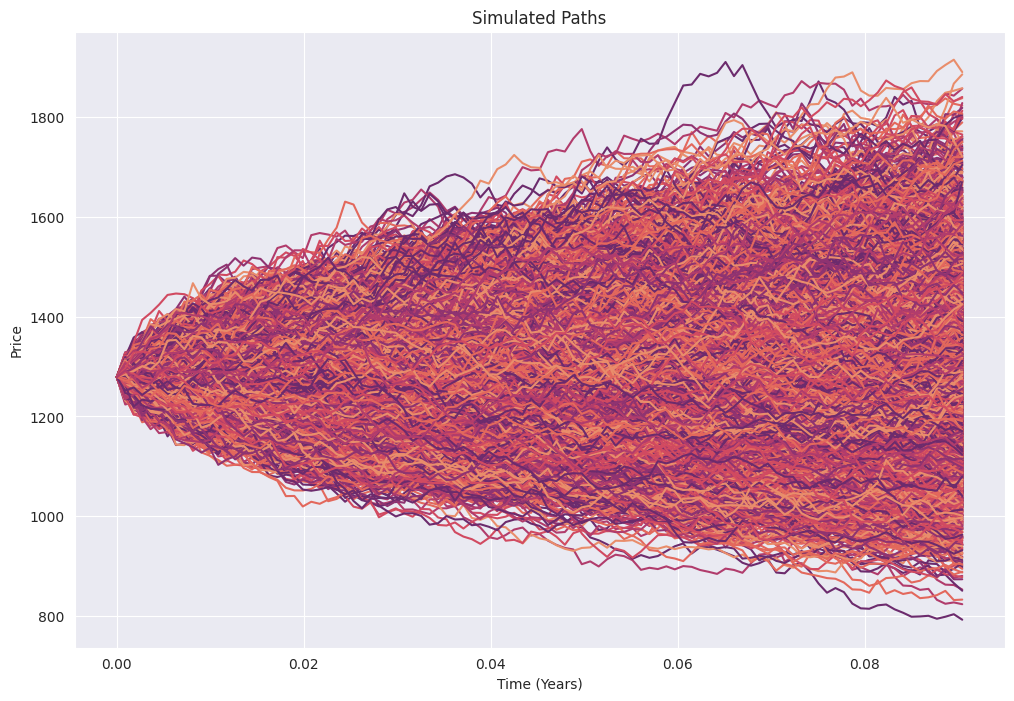

In [68]:
optionSimulation_Historical.plotPaths()